# Анализ данных в задаче кредитного скоринга

In [170]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats



Populating the interactive namespace from numpy and matplotlib


C:\Users\asaparov\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [171]:
data = pd.read_csv('credit_card_default_analysis.csv', sep=",")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Размер кредитного лимита (LIMIT_BAL)

#### Гипотеза о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  

In [172]:
default = data[data.default == 1]['LIMIT_BAL'].values
not_default = data[data.default == 0]['LIMIT_BAL'].values

(array([ 3246.,  1263.,   916.,   606.,   319.,   121.,   146.,    10.,
            5.,     4.]),
 array([  10000.,   83000.,  156000.,  229000.,  302000.,  375000.,
         448000.,  521000.,  594000.,  667000.,  740000.]),
 <a list of 10 Patch objects>)

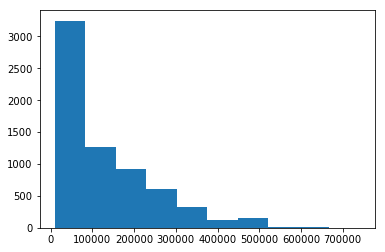

In [173]:
pylab.hist(default)

(array([  8.81400000e+03,   6.34500000e+03,   4.24700000e+03,
          2.37100000e+03,   1.40400000e+03,   1.10000000e+02,
          5.30000000e+01,   1.90000000e+01,   0.00000000e+00,
          1.00000000e+00]),
 array([   10000.,   109000.,   208000.,   307000.,   406000.,   505000.,
          604000.,   703000.,   802000.,   901000.,  1000000.]),
 <a list of 10 Patch objects>)

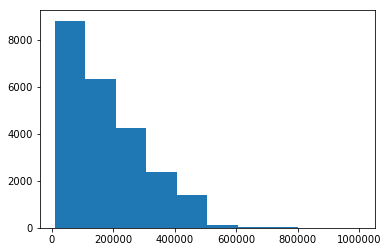

In [174]:
pylab.hist(not_default)

In [175]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [176]:
%%time
np.random.seed(0)

default_scores = map(np.median, get_bootstrap_samples(default, 1000))
not_default_scores = map(np.median, get_bootstrap_samples(not_default, 1000))

print "95% confidence interval for default=1 median LIMIT_BAL:",  stat_intervals(default_scores, 0.05)
print "95% confidence interval for default=0 median LIMIT_BAL:",  stat_intervals(not_default_scores, 0.05)

95% confidence interval for default=1 median LIMIT_BAL: [ 80000.  90000.]
95% confidence interval for default=0 median LIMIT_BAL: [ 150000.  150000.]
Wall time: 983 ms


In [177]:
median_scores = zip(map(np.median, default_scores), map(np.median, not_default_scores))

In [178]:
delta_median_scores = map(lambda x: x[1] - x[0], median_scores)

In [179]:
print "95% confidence interval for the difference between median:",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between median: [ 60000.  70000.]


#### Гипотеза о равенстве распределений 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [180]:
import itertools
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.70000000e+01,   3.53400000e+03,
          1.43800000e+03]),
 array([-47990.06965477, -42541.50239329, -37092.93513181, -31644.36787032,
        -26195.80060884, -20747.23334736, -15298.66608587,  -9850.09882439,
         -4401.53156291,   1047.03569857,   6495.60296006]),
 <a list of 10 Patch objects>)

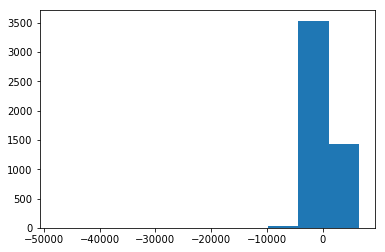

In [181]:
pylab.hist(permutation_zero_dist_ind(default, not_default, 5000))

In [182]:
permutation_test(default, not_default, max_permutations = 5000)

0.00020000000000000001

Гипотеза отвергается

## Образование (EDUCATION)

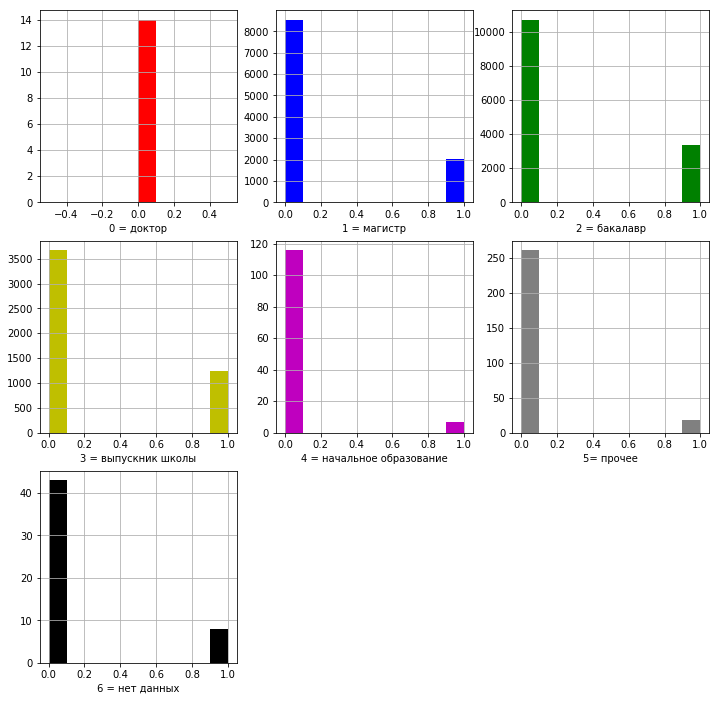

In [183]:
def d(e):
    return data[data.EDUCATION == e].default

pylab.figure(figsize=(12,12))

pylab.subplot(3,3,1)
pylab.grid()
pylab.hist(d(0), color = 'r')
pylab.xlabel(u'0 = доктор')

pylab.subplot(3,3,2)
pylab.grid()
pylab.hist(d(1), color = 'b')
pylab.xlabel(u'1 = магистр')

pylab.subplot(3,3,3)
pylab.grid()
pylab.hist(d(2), color = 'g')
pylab.xlabel(u'2 = бакалавр')

pylab.subplot(3,3,4)
pylab.grid()
pylab.hist(d(3), color = 'y')
pylab.xlabel(u'3 = выпускник школы')

pylab.subplot(3,3,5)
pylab.grid()
pylab.hist(d(4), color = 'm')
pylab.xlabel(u'4 = начальное образование')

pylab.subplot(3,3,6)
pylab.grid()
pylab.hist(d(5), color = 'grey')
pylab.xlabel(u'5= прочее')

pylab.subplot(3,3,7)
pylab.grid()
pylab.hist(d(6), color = 'black')
pylab.xlabel(u'6 = нет данных')


pylab.show()

In [184]:
default_edu = data[data.default == 1].EDUCATION.values
print len(default_edu)
not_default_edu = data[data.default == 0].EDUCATION.values
print len(not_default_edu)

default_edu_mean = np.mean(default_edu)
print default_edu_mean
not_default_edu_mean = np.mean(not_default_edu)
print not_default_edu_mean

default_observed_frequences = map(lambda x: np.log(x+1), np.bincount(default_edu))
not_default_observed_frequences = map(lambda x: np.log(x+1), np.bincount(not_default_edu))
default_expected_frequences = [np.log(len(default_edu)*stats.poisson.pmf(x, default_edu_mean)) for x in range(7)]
not_default_expected_frequences = [np.log(len(not_default_edu)*stats.poisson.pmf(x, not_default_edu_mean)) for x in range(7)]

6636
23364
1.89466546112
1.84133709981


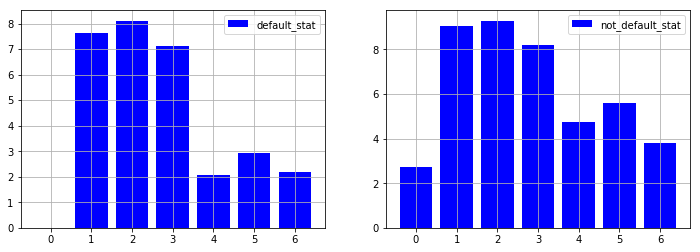

In [185]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.bar(range(7), default_observed_frequences, color = 'b', label = 'default_stat')
pylab.legend()

pylab.subplot(1,2,2)
pylab.grid()
pylab.bar(range(7), not_default_observed_frequences, color = 'b', label = 'not_default_stat')
pylab.legend()

pylab.show()

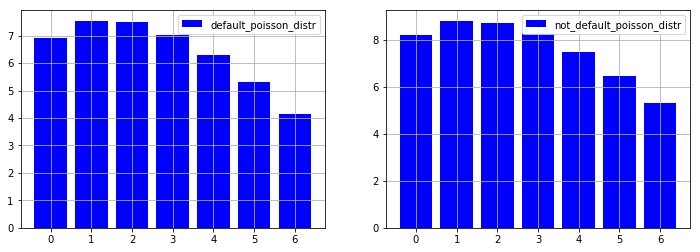

In [186]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.bar(range(len(default_expected_frequences)), default_expected_frequences, color = 'b', label = 'default_poisson_distr')
pylab.legend()

pylab.subplot(1,2,2)
pylab.grid()
pylab.bar(range(len(not_default_expected_frequences)), not_default_expected_frequences, \
          color = 'b', label = 'not_default_poisson_distr')
pylab.legend()

pylab.show()

In [187]:
stats.chisquare(default_observed_frequences[1:], default_expected_frequences[1:], ddof = 1)

Power_divergenceResult(statistic=4.8489174183372183, pvalue=0.30315371524773327)

In [188]:
stats.chisquare(not_default_observed_frequences, not_default_expected_frequences, ddof = 1)

Power_divergenceResult(statistic=5.2828480706668666, pvalue=0.3823449245987201)

In [189]:
stats.chisquare(observed_frequences[1:], expected_frequences[1:], ddof = 1)

Power_divergenceResult(statistic=2083.1144819489846, pvalue=0.0)

На гистограмме для докторов видно, что все они возвращают долг и значит является наилучшим индикатором того, что человек отдаст долг.



## Пол (SEX)

Интревальная оценка долей

In [190]:
default = data[data.default == 1].SEX.values - 1
not_default = data[data.default == 0].SEX.values - 1

(array([ 2873.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3763.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

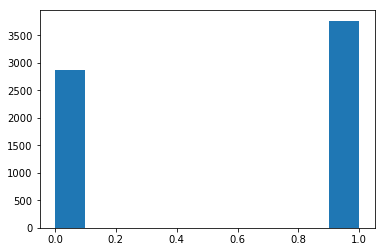

In [191]:
pylab.hist(default)

(array([  9015.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  14349.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

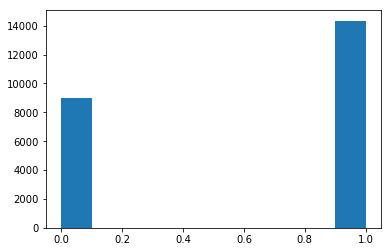

In [192]:
pylab.hist(not_default)

In [193]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [194]:
conf_interval_default = proportion_confint(sum(default), 
                                            len(default),
                                            method = 'wilson')
conf_interval_not_default = proportion_confint(sum(not_default), 
                                            len(not_default),
                                            method = 'wilson')

In [195]:
print '95%% confidence interval for default: [%f, %f]' % conf_interval_default
print '95%% confidence interval for not_default [%f, %f]' % conf_interval_not_default

95% confidence interval for default: [0.555102, 0.578938]
95% confidence interval for not_default [0.607890, 0.620373]


Интервалы не пересекаются, значит гендерный состав людей вернувшизх и не вернувших отличается

Имеем распредление Бернулли, а значит используем  Z-критерий для разности долей (независимые выборки)

$H_0\colon p_1 = p_2$

$H_1\colon p_1 \neq  p_2$

In [196]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [197]:
print "95%% confidence interval for a difference: [%f, %f]" %\
      proportions_diff_confint_ind(default, not_default)

95% confidence interval for a difference: [-0.060548, -0.033635]


In [198]:
print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(default, not_default))

p-value: 0.000000


Гипотеза отвергается: гендерный сотав различен.

## Семейное положение (MARRIAGE)

Здесь будем использовать коэфициент V Крамера

In [199]:
def m(dflt, marr):
    return data[(data.default == dflt) & (data.MARRIAGE == marr)].shape[0]
M = [[m(dflt, marr) for marr in range(4)] for dflt in range(2)]
M

[[49, 10453, 12623, 239], [5, 3206, 3341, 84]]

(array([    5.,     0.,     0.,  3206.,     0.,     0.,  3341.,     0.,
            0.,    84.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

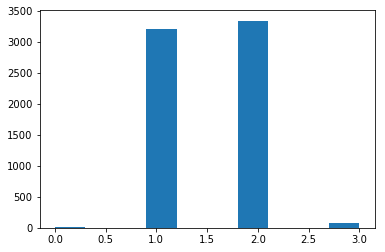

In [200]:
pylab.hist(data[data.default == 1].MARRIAGE)

(array([    49.,      0.,      0.,  10453.,      0.,      0.,  12623.,
             0.,      0.,    239.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

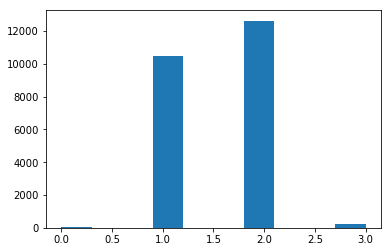

In [201]:
pylab.hist(data[data.default == 0].MARRIAGE)

In [202]:
chi2, p, _, _ = scipy.stats.chi2_contingency(M)
n = sum(map(lambda x: sum(x), M))
# 1 == min(2,4)-1
V = np.sqrt(chi2/n)
V

0.034478203662766466

Значение близко к нулю, значит отсутствует взаимосвязь

## Возраст (AGE)

In [203]:
default = data[data.default == 1]['AGE'].values
not_default = data[data.default == 0]['AGE'].values

(array([ 1285.,  1415.,  1380.,   950.,   705.,   564.,   220.,    89.,
           21.,     7.]),
 array([ 21. ,  26.4,  31.8,  37.2,  42.6,  48. ,  53.4,  58.8,  64.2,
         69.6,  75. ]),
 <a list of 10 Patch objects>)

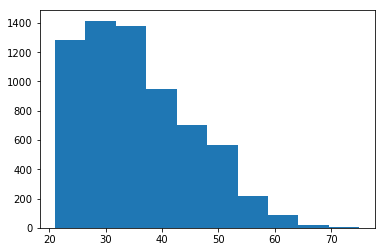

In [204]:
pylab.hist(default)

(array([  3.84200000e+03,   6.62100000e+03,   5.16500000e+03,
          3.74400000e+03,   1.99000000e+03,   1.38200000e+03,
          4.56000000e+02,   1.30000000e+02,   3.00000000e+01,
          4.00000000e+00]),
 array([ 21. ,  26.8,  32.6,  38.4,  44.2,  50. ,  55.8,  61.6,  67.4,
         73.2,  79. ]),
 <a list of 10 Patch objects>)

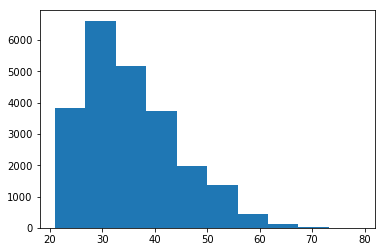

In [205]:
pylab.hist(not_default)

#### Гипотеза о равенстве медианных значений возрастов людей

$H_0\colon$ медианы возрастов, что вернули и не вернули кредит совпадают

$H_1\colon$ медианы возрастов, что вернули и не вернули кредит не совпадают

In [206]:
print zconfint(default)
print zconfint(not_default)

(35.492514653706728, 35.958962139542216)
(35.300871020374075, 35.533660737886493)


95% доверительные интервалы почти одинаковый, проверим еще гипотезу с помощью критерия Манна-Уитни

$H_0\colon P(X > Y) = \frac1{2}$ 

$H_1\colon  P(X > Y) ≠ \frac1{2}$

In [207]:
stats.mannwhitneyu(default, not_default)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

Отвергнуть нулевую гипотезу не можем

#### Гипотеза о равенстве распределений

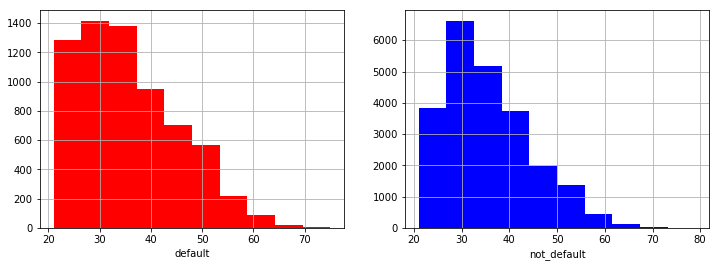

In [210]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(default, color = 'r')
pylab.xlabel('default')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(not_default, color = 'b')
pylab.xlabel('not_default')


pylab.show()

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [209]:
permutation_test(default, not_default, max_permutations = 5000)

0.0172

Гипотеза отвергается